# Projet d'analyse de survie — Master 2 MIASHS
**Analyse des données de récidive de cancer (COBIRE)**

**Livrable** : Notebook exécutable (code + rédactions soignées).  
**Auteur** : BOURHANE Bedja Ben Ahmed & TIEMTORE Wendyam Ariel Clauvis Eddy

**Plan**
1. Chargement et description des données  
2. Préparation et recodage des variables  
3. Analyse descriptive (statistiques & graphiques)  
4. Analyse de survie non-paramétrique (Kaplan-Meier + log-rank)  
5. Modélisation multivariée (Cox PH)  
6. Validation du modèle (C-index, test PH)  
7. Modèle paramétrique (Weibull)  
8. Synthèse et interprétation



# Installation des différents packages et bibliothèques pour notre analyse

In [ ]:
!pip install pandas numpy matplotlib seaborn

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=e198300deaed4a88579f2d8f77e99f076c2087116de3018f377506778bc9d1c5
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.8 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.5
    Uninstalling osqp-1.0.5:
      Successfully uninstalled osqp-1.0.5


In [ ]:
# Imports et configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
import scipy.stats as stats
from scipy.stats import chi2_contingency

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_context("notebook")


## 1. Chargement et présentation des données




In [ ]:

# Chargement (séparateur whitespace)
df = pd.read_csv('/content/cobire.txt', delimiter=r"\s+")
print("Shape:", df.shape)
print("Colonnes :", df.columns.tolist())
df.head().T


Shape: (255, 8)
Colonnes : ['AGE', 'DIMTUM', 'SBR', 'TRAIT', 'ETATDER', 'DELAISV', 'RECLOC', 'DELAIREC']


,0,1,2,3,4
AGE,54,61,49,48,54
DIMTUM,7,4,4,5,4
SBR,III,II,II,ND,ND
TRAIT,1,1,1,1,2
ETATDER,0,0,0,1,0
DELAISV,98,72,98,76,106
RECLOC,0,1,1,0,0
DELAIREC,98,50,81,76,106


### Description de l'étude et des variables de la base
L’essai thérapeutique COBIRE est un essai randomisé prospectif pour comparer le nouveau
traitement par l’iridium au traitement conventionnel par le cobalt pour retarder la survenue de
récidives chez des patientes en rémission du cancer du sein.
Le fichier de données cobire.txt comporte deux couples de variables de survie (délai jusqu’à
l’événement, indicatrice d’événement) :  
-la survie : (DELAISV, ETATDER)
-la survenue d’une récidive : (DELAIREC, RECLOC).  
Les covariables de l’étude sont les suivantes :  
-AGE : âge au début de l’étude (en années)  
-DIMTUM : dimension de la tumeur (en cm)
-SBR : grade histologique de Scarff-Blomm et Richardson. ND (non déterminé)
correspond à un grading impossible. Les autres valeurs (en chiffres romains)
correspondent à des stades croissants de gravité du cancer.  
-TRAIT : groupe de traitement (1 : cobalt, 2 : iridium)

In [ ]:
print("Taille échantillon :", len(df))
print("\nDescriptives numériques :")
display(df[['AGE','DIMTUM','DELAISV','DELAIREC']].describe().T)
print("\nEffectifs par modalité (quelques variables) :")
display(df['TRAIT'].value_counts(dropna=False))
display(df['SBR'].value_counts(dropna=False))
display(df['RECLOC'].value_counts(dropna=False))


Taille échantillon : 255

Descriptives numériques :


,count,mean,std,min,25%,50%,75%,max
AGE,255.0,52.250980,10.604920,29.0,44.0,52.0,60.0,78.0
DIMTUM,255.0,4.745098,1.636723,1.0,4.0,4.0,6.0,10.0
DELAISV,255.0,81.792157,28.137597,12.0,64.0,83.0,107.0,125.0
DELAIREC,255.0,71.113725,33.080057,9.0,41.0,76.0,99.0,125.0



Effectifs par modalité (quelques variables) :


,count
TRAIT,
1,129
2,126


,count
SBR,
II,124
III,57
ND,39
I,35


,count
RECLOC,
0,182
1,73


On constate dans notre base de données que la moyenne d'âge est de 52 ans, la dimension moyenne de la tumeur est de 4 cm.  Aussi, on note que parmis les patients, 129 sont traités avec le cobalt et 126 avec l'iriduim.

## 2. Préparation et recodage

On recode les variables pour faciliter l'analyse :
- labels lisibles (ex. `Cobalt`/`Iridium`)
- versions catégorielles pour graphiques
- versions numériques (0/1) pour la régression de Cox


In [ ]:
# Recodage lisible
df = df.copy()
df['TRAIT_REC'] = df['TRAIT'].map({1: 'Cobalt', 2: 'Iridium'})
df['RECLOC_REC'] = df['RECLOC'].map({0: 'Non-récidive', 1: 'Récidive'})
df['ETATDER_REC'] = df['ETATDER'].map({0: 'Survie', 1: 'Décès'})

# Catégories
df['AGE_CAT'] = pd.cut(df['AGE'], bins=[0,40,200], labels=['<40 ans','≥40 ans'])
df['DIMTUM_CAT'] = pd.cut(df['DIMTUM'], bins=[0,5,100], labels=['<5cm','≥5cm'])
df['SBR_CAT'] = df['SBR'].replace({'I':'Stade 1','II':'Stade 1','III':'Stade 2','ND':'Stade 1'})

# Versions numériques
df['TRAIT_NUM'] = df['TRAIT'].map({1:0, 2:1})
df['AGE_NUM'] = (df['AGE'] >= 40).astype(int)
df['DIMTUM_NUM'] = (df['DIMTUM'] >= 5).astype(int)
df['SBR_NUM'] = df['SBR'].map({'I':0,'II':0,'III':1,'ND':0})


## 3. Statistiques descriptives et visualisations
Affichage des distributions pour `AGE`, `DIMTUM`, `DELAIREC`, et effectifs pour catégories.


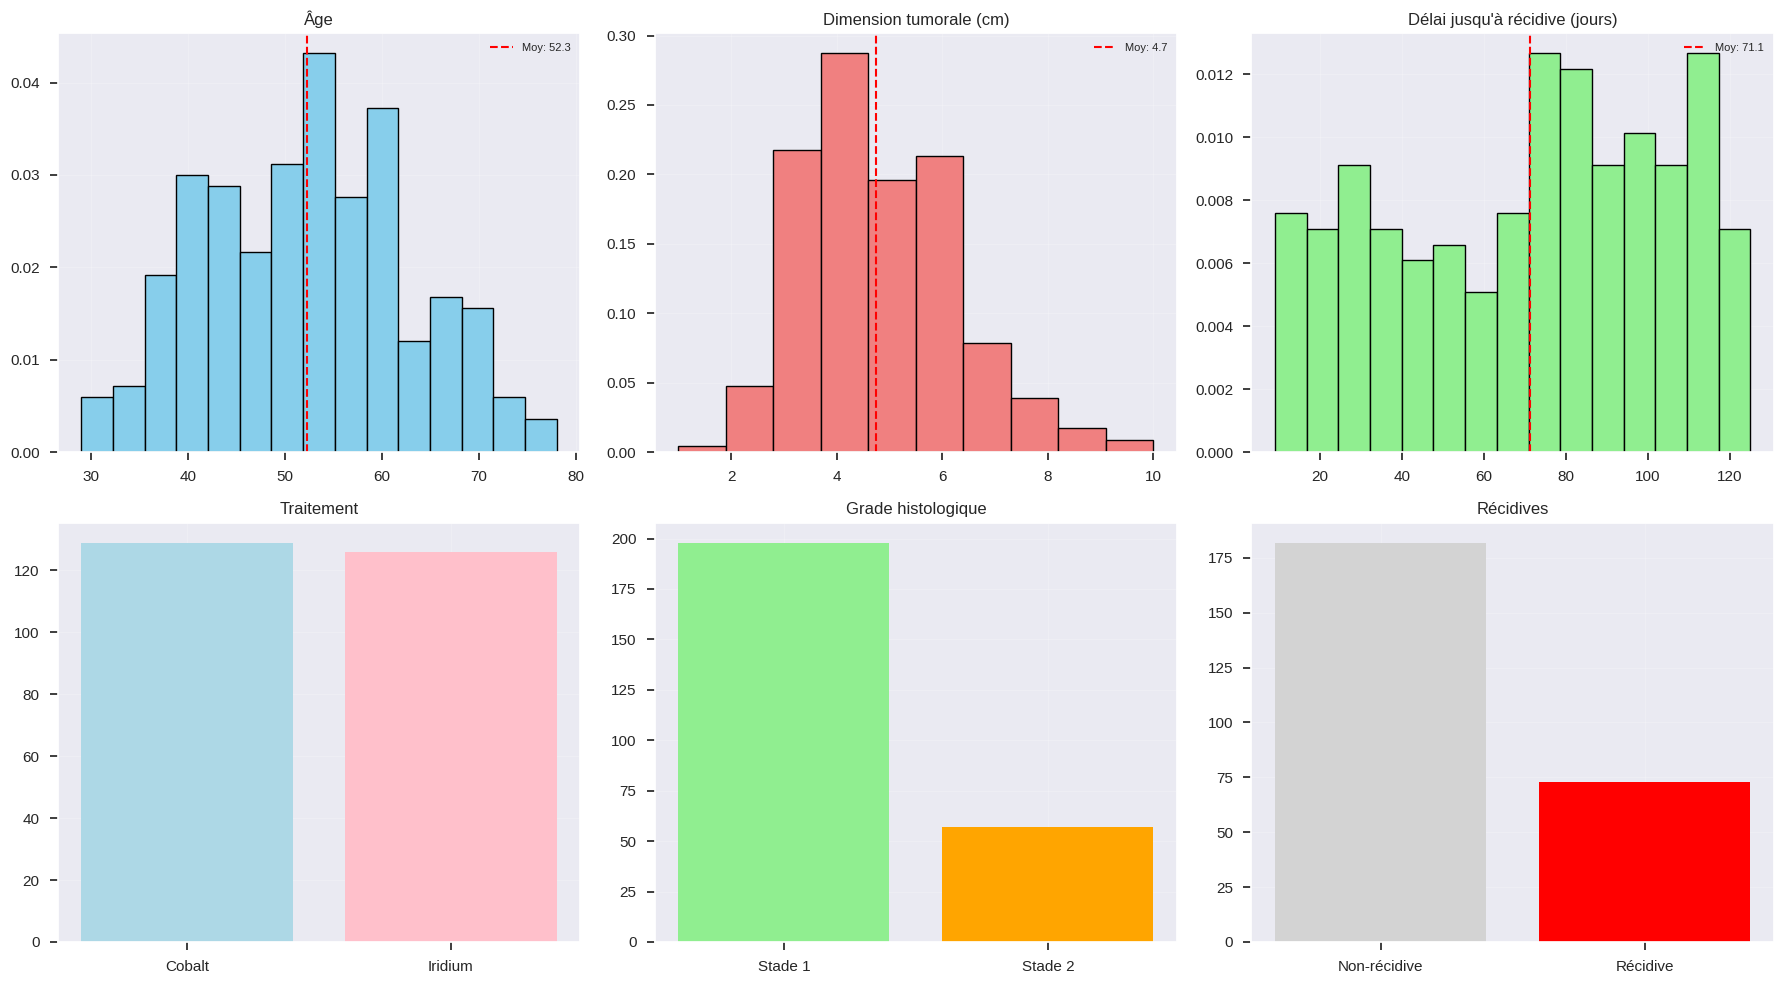

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(18,10))

axes = axes.ravel()
axes[0].hist(df['AGE'].dropna(), bins=15, density=True, color='skyblue', edgecolor='k')
axes[0].axvline(df['AGE'].mean(), color='red', linestyle='--', label=f"Moy: {df['AGE'].mean():.1f}")
axes[0].set_title("Âge")

axes[1].hist(df['DIMTUM'].dropna(), bins=10, density=True, color='lightcoral', edgecolor='k')
axes[1].axvline(df['DIMTUM'].mean(), color='red', linestyle='--', label=f"Moy: {df['DIMTUM'].mean():.1f}")
axes[1].set_title("Dimension tumorale (cm)")

axes[2].hist(df['DELAIREC'].dropna(), bins=15, density=True, color='lightgreen', edgecolor='k')
axes[2].axvline(df['DELAIREC'].mean(), color='red', linestyle='--', label=f"Moy: {df['DELAIREC'].mean():.1f}")
axes[2].set_title("Délai jusqu'à récidive (jours)")

# bars
axes[3].bar(df['TRAIT_REC'].value_counts().index, df['TRAIT_REC'].value_counts().values, color=['lightblue','pink'])
axes[3].set_title("Traitement")

axes[4].bar(df['SBR_CAT'].value_counts().index, df['SBR_CAT'].value_counts().values, color=['lightgreen','orange'])
axes[4].set_title("Grade histologique")

axes[5].bar(df['RECLOC_REC'].value_counts().index, df['RECLOC_REC'].value_counts().values, color=['lightgray','red'])
axes[5].set_title("Récidives")

for ax in axes:
    ax.grid(alpha=0.2)
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
n_total = len(df)
n_events = df['RECLOC'].sum()
n_censored = n_total - n_events
print(f"Total = {n_total}, événements = {n_events} ({n_events/n_total:.1%}), censurés = {n_censored} ({n_censored/n_total:.1%})")


Total = 255, événements = 73 (28.6%), censurés = 182 (71.4%)


## Comparaison des caractéristiques basales entre groupes (Cobalt vs Iridium)
On teste la comparabilité des groupes pour l'âge et la taille tumorale (t-tests) et pour les variables catégorielles (chi²).


In [ ]:
# t-tests
t_age, p_age = stats.ttest_ind(df[df['TRAIT_NUM']==0]['AGE'].dropna(), df[df['TRAIT_NUM']==1]['AGE'].dropna(), equal_var=False)
t_dim, p_dim = stats.ttest_ind(df[df['TRAIT_NUM']==0]['DIMTUM'].dropna(), df[df['TRAIT_NUM']==1]['DIMTUM'].dropna(), equal_var=False)

print("Âge: p=", p_age)
print("Dimension: p=", p_dim)

# chi2
cont_grade = pd.crosstab(df['TRAIT_REC'], df['SBR_CAT'])
chi2_g, p_g, _, _ = chi2_contingency(cont_grade)
cont_agecat = pd.crosstab(df['TRAIT_REC'], df['AGE_CAT'])
chi2_a, p_a, _, _ = chi2_contingency(cont_agecat)

print("Grade vs Traitement : p=", p_g)
print("AgeCat vs Traitement : p=", p_a)


Âge: p= 0.2271291631750725
Dimension: p= 0.17125849683329464
Grade vs Traitement : p= 0.08855131010981104
AgeCat vs Traitement : p= 0.27199522019484673


-En considérant l’hypothèse, H0 : les moyennes sont identiques et H1 : il y a une différence entre les moyennes, on constate avec le ttest qu’on accepte H0 car p-value de H1 est supérieure au seuil de 5%. Ainsi on peut dire qu’en considérant individuellement les variables âge et dimension de la tumeur on constate qu’il n’y a pas de différence entre la moyenne des deux groupes de traitement.     
-La variable grade histologique n’étant pas quantitative nous avons procéder à un test non paramétrique notamment le test de chi2. Ainsi, on constate que la p-value supérieur au seuil. Alors nous ne pouvons pas dire qu’il y a une association significative entre le grade histologique et le groupe de traitement.


## 4. Analyse de survie non-paramétrique (Kaplan–Meier)
Calcul de la courbe KM globale, de la médiane de survie et estimation approximative de l'IC 95% de la médiane à partir des intervalles de confiance de la fonction de survie.


Médiane (approx) : inf
IC approximatif 95% de la médiane : [nan, nan] jours


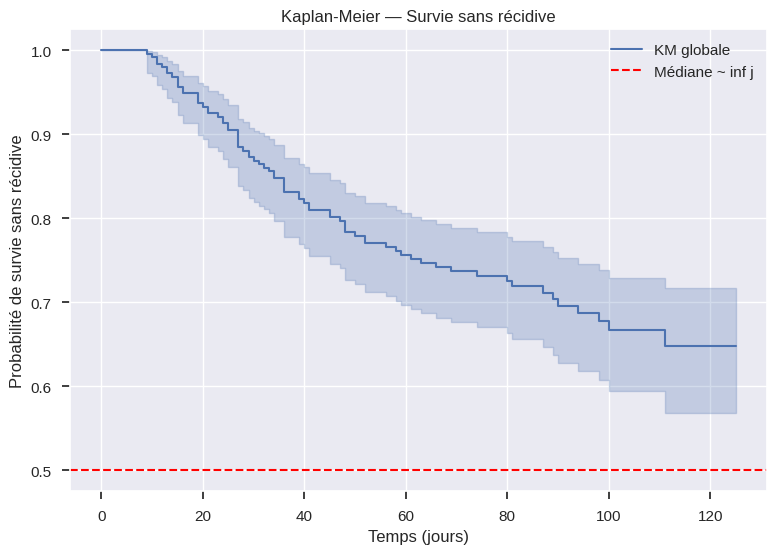

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(df['DELAIREC'], event_observed=df['RECLOC'], label='KM globale')

ax = kmf.plot_survival_function(ci_show=True, figsize=(9,6))
plt.title("Kaplan-Meier — Survie sans récidive")
plt.xlabel("Temps (jours)")
plt.ylabel("Probabilité de survie sans récidive")

median = kmf.median_survival_time_
print("Médiane (approx) :", median)

# Approximation CI de la médiane : on cherche la plus petite t où la borne inférieure/ supérieure de la survie < 0.5
ci_sf = kmf.confidence_interval_survival_function_
# colonne order: lower, upper
lower_col = ci_sf.columns[0]
upper_col = ci_sf.columns[1]

# temps où lower CI passe sous 0.5
try:
    t_lower = ci_sf[ci_sf[lower_col] < 0.5].index.min()
    t_upper = ci_sf[ci_sf[upper_col] < 0.5].index.min()
    print(f"IC approximatif 95% de la médiane : [{t_lower:.1f}, {t_upper:.1f}] jours")
except Exception as e:
    print("Impossible d'estimer automatiquement l'IC de la médiane :", e)

plt.axhline(0.5, color='red', linestyle='--')
plt.axvline(median, color='red', linestyle='--', label=f"Médiane ~ {median:.1f} j")
plt.legend()
plt.show()


La médiane n’est pas atteinte, donc on ne peut pas estimer statistiquement un intervalle de confiance.

Le suivi est trop court ou les événements trop rares pour estimer une médiane de survie

## 5. Comparaisons des courbes de survie par sous-groupes
On trace les courbes KM par groupe (Traitement, Age, DIMTUM, SBR) et on effectue le test du log-rank (pour 2 groupes).



--- Traitement


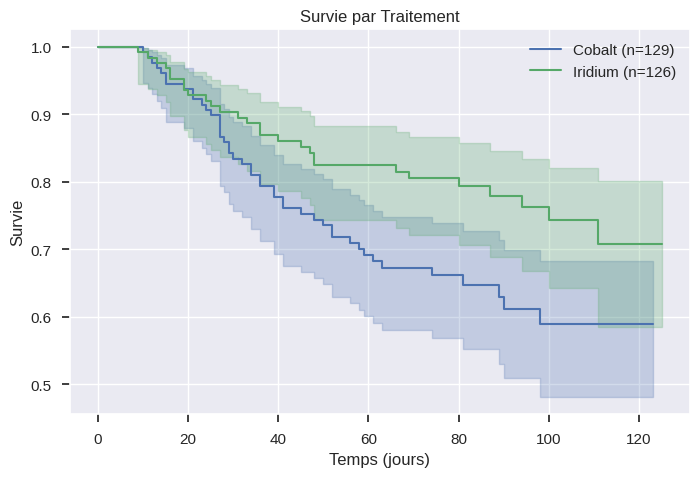

Log-rank p = 0.02030149873557917

--- Âge


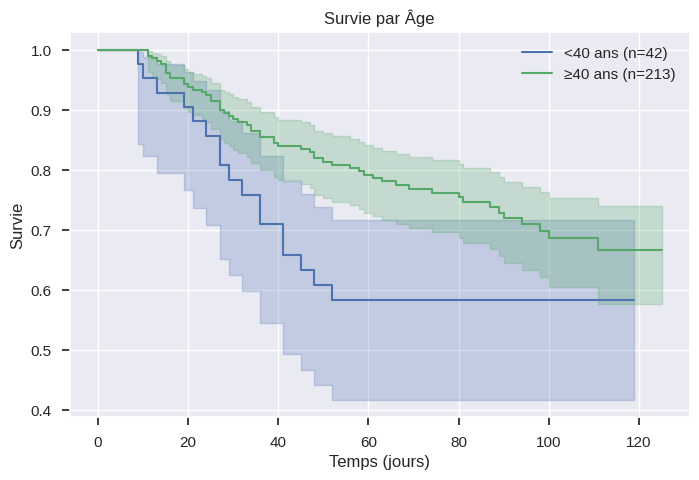

Log-rank p = 0.03014770881623759

--- Dimension


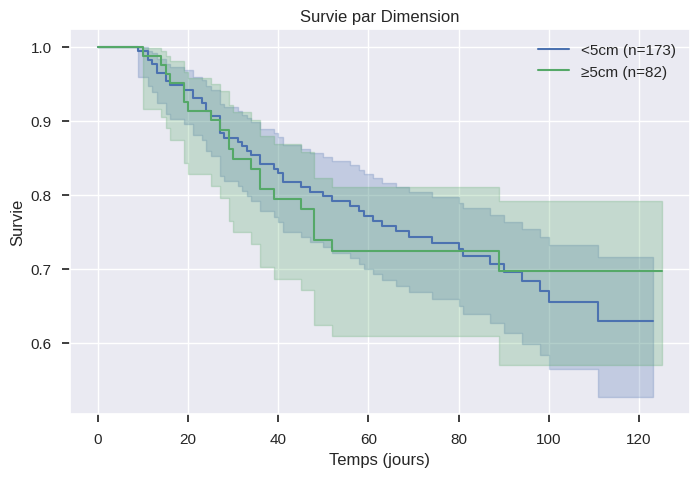

Log-rank p = 0.9151181365946848

--- Grade


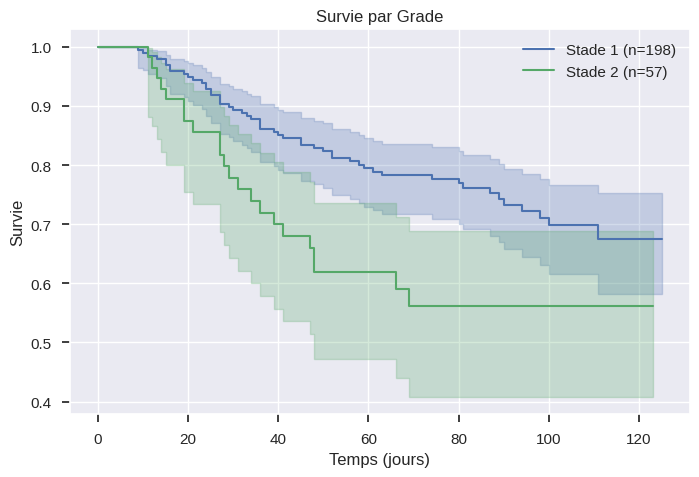

Log-rank p = 0.0076915287199783


In [ ]:
group_cols = {
    'TRAIT_REC': ('Traitement', ['Cobalt','Iridium']),
    'AGE_CAT': ('Âge', ['<40 ans','≥40 ans']),
    'DIMTUM_CAT': ('Dimension', ['<5cm','≥5cm']),
    'SBR_CAT': ('Grade', ['Stade 1','Stade 2'])
}

results_logrank = {}

for col, (label, groups) in group_cols.items():
    print("\n---", label)
    plt.figure(figsize=(8,5))
    for g in groups:
        mask = df[col] == g
        if mask.sum() == 0:
            continue
        kmf.fit(df.loc[mask,'DELAIREC'], df.loc[mask,'RECLOC'], label=f"{g} (n={mask.sum()})")
        kmf.plot_survival_function(ci_show=True)
    plt.title(f"Survie par {label}")
    plt.xlabel("Temps (jours)")
    plt.ylabel("Survie")
    plt.legend(); plt.show()
    if len(groups) == 2:
        m1 = df[col] == groups[0]
        m2 = df[col] == groups[1]
        lr = logrank_test(df.loc[m1,'DELAIREC'], df.loc[m2,'DELAIREC'], df.loc[m1,'RECLOC'], df.loc[m2,'RECLOC'])
        results_logrank[label] = lr.p_value
        print("Log-rank p =", lr.p_value)


En faisant une estimation de la survie on obtient les graphiques précédents. Pour tester les différences entre les courbes on a réalisé un test de log-rank avec les hypothèses suivantes:

H0: il n’y a aucune différence significative entre les courbes de survie.


H1: il existe une différence de survie entre les groupes.

Si p < 0.05 → on rejette l’hypothèse nulle → les courbes de survie sont significativement différentes.

Si p ≥ 0.05 → on ne rejette pas H₀ → aucune différence significative.

 On voit alors que pour les variables (traitement, âge et grade), p<0.05 alors on rejette H0 cela montre qu'il y a une différence significative entre les courbes de survie du traitement (iriduim et cobalt), âge (moins de 40 ans et plus de 40 ans) et grade (stade 1 et stade 2).

 Cependant, pour la variable dimension de la tumeur, p≥0.05 alors on ne rejette pas l'hypothèse nulle, cela implique il n'y a aucune différence entre les différentes courbes de survie de la dimension (moins de 5cm et plus de 5cm).

 En résumé, il y a un effet de l’âge, du traitement et du grade histologique  sur le délai de recidive par contre il n'y a pas d'effet de la dimension de la tumeur sur le délai de recidive.


## 6. Modélisation multivariée : modèle de Cox proportionnel

Le modèle de Cox s'écrit :
$$
h(t|X) = h_0(t) \exp\left(\sum_{j}\beta_j X_j\right)
$$
avec $X_j$ les covariables (TRAIT, AGE, DIMTUM, SBR).
On ajuste le modèle et on interprète les hazard ratios $$e^{\beta_j}.$$


<lifelines.CoxPHFitter: fitted with 255 total observations, 182 right-censored observations>
             duration col = 'DELAIREC'
                event col = 'RECLOC'
      baseline estimation = breslow
   number of observations = 255
number of events observed = 73
   partial log-likelihood = -373.36
         time fit was run = 2025-11-13 16:28:24 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
TRAIT_NUM  -0.46      0.63      0.24           -0.93            0.02                0.39                1.02
AGE_NUM    -0.44      0.65      0.31           -1.04            0.17                0.35                1.18
DIMTUM_NUM  0.36      1.43      0.24           -0.11            0.83                0.90                2.30
SBR_NUM     0.54      1.72      0.26            0.03            1.06                1.03                2.88

            cmp to     z    p  -log2(p)
covariate                              
TRAIT_NUM     0.00 -1.88 0.06      4.04
AGE_NUM       0.00 -1.42 0.15      2.69
DIMTUM_NUM    0.00  1.50 0.13      2.92
SBR_NUM       0.00  2.07 0.04      4.71
---
Concordance = 0.65
Partial AIC = 754.72
log-likelihood ratio test = 15.28 on 4 df
-log2(p) of ll-ratio test = 7.91

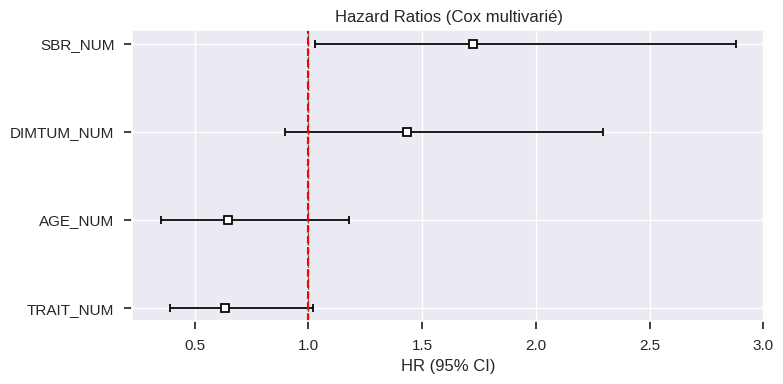

In [ ]:
# Préparation du DataFrame pour Cox
cox_df = df[['DELAIREC','RECLOC','TRAIT_NUM','AGE_NUM','DIMTUM_NUM','SBR_NUM']].dropna()

cph = CoxPHFitter()
cph.fit(cox_df, duration_col='DELAIREC', event_col='RECLOC')
cph.print_summary()

# Visualiser HR
plt.figure(figsize=(8,4))
cph.plot(hazard_ratios=True)
plt.title("Hazard Ratios (Cox multivarié)")
plt.axvline(1, color='red', linestyle='--')
plt.tight_layout()
plt.show()


### Interprétation

Pour chaque covariable on récupère :
- coefficient $\hat\beta$, hazard ratio $e^{\hat\beta}$, IC95% et p-value.

Interprétation: "HR >1 : risque accru ; HR <1 : effet protecteur".


In [ ]:
summary = cph.summary
for var in summary.index:
    hr = summary.loc[var,'exp(coef)']
    lower = summary.loc[var,'exp(coef) lower 95%']
    upper = summary.loc[var,'exp(coef) upper 95%']
    pval = summary.loc[var,'p']
    sig = "SIGNIFICATIF" if pval < 0.05 else "Non significatif"
    direction = "risque accru" if hr > 1 else f"risque réduit de {1/hr:.2f} fois"
    print(f"{var}: HR={hr:.3f} (IC95% [{lower:.3f}, {upper:.3f}]), p={pval:.4f} -> {direction} ({sig})")


TRAIT_NUM: HR=0.633 (IC95% [0.393, 1.021]), p=0.0606 -> risque réduit de 1.58 fois (Non significatif)
AGE_NUM: HR=0.646 (IC95% [0.354, 1.179]), p=0.1548 -> risque réduit de 1.55 fois (Non significatif)
DIMTUM_NUM: HR=1.434 (IC95% [0.896, 2.295]), p=0.1325 -> risque accru (Non significatif)
SBR_NUM: HR=1.722 (IC95% [1.030, 2.881]), p=0.0383 -> risque accru (SIGNIFICATIF)


En résumé on note que seule SBR_NUM (grade histologique) a un effet significatif sur la survie : plus son niveau augmente, plus le risque de recidive augmente. Les autres variables montrent des tendances (TRAIT_NUM et AGE_NUM protectrices) mais sans significativité statistique (p > 0.05).

## 7. Validation du modèle
- Indice de concordance (C-index) pour mesurer la discrimination.  
- Test des risques proportionnels (proportional_hazard_test).


In [ ]:
c_index = cph.concordance_index_
print("C-index:", c_index)

# proportional_hazard_test retourne un object TestResult (DataFrame)
try:
    ph_test = proportional_hazard_test(cph, cox_df, time_transform='rank')
    # ph_test.summary est un DataFrame sur les covariables + global
    display(ph_test.summary)
    # p-value globale approximée : on peut regarder la colonne p une par une.
except Exception as e:
    print("Erreur test PH:", e)


C-index: 0.6526517300056721


,test_statistic,p,-log2(p)
AGE_NUM,0.351685,0.553161,0.854230
DIMTUM_NUM,0.538234,0.463165,1.110401
SBR_NUM,0.881801,0.347709,1.524048
TRAIT_NUM,0.474620,0.490870,1.026588


**Interprétation générale :**

Aucun facteur explicatif n’est statistiquement significatif (toutes les p > 0.05).

Le modèle capture une tendance générale du risque, mais aucune variable isolée ne ressort comme déterminante.

Le modèle de survie présente une performance modérée (C-index ≈ 0.65), ce qui suggère une certaine capacité de discrimination, mais sans facteur significatif clair c'est pour cela nous allons faire un autre modèle avec Elastic net.


 COX ELASTIC NET 


<lifelines.CoxPHFitter: fitted with 255 total observations, 182 right-censored observations>
             duration col = 'DELAIREC'
                event col = 'RECLOC'
                penalizer = 0.1
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 255
number of events observed = 73
   partial log-likelihood = -380.20
         time fit was run = 2025-11-13 16:28:58 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
TRAIT_NUM  -0.14      0.87      0.22           -0.57            0.29                0.57                1.33
AGE_NUM    -0.14      0.87      0.33           -0.78            0.50                0.46                1.65
DIMTUM_NUM  0.05      1.06      0.22           -0.37            0.48                0.69                1.62
SBR_NUM     0.22      1.24      0.26           -0.30            0.73                0.74                2.08

            cmp to     z    p  -log2(p)
covariate                              
TRAIT_NUM     0.00 -0.64 0.52      0.93
AGE_NUM       0.00 -0.43 0.67      0.58
DIMTUM_NUM    0.00  0.25 0.80      0.32
SBR_NUM       0.00  0.81 0.42      1.27
---
Concordance = 0.66
Partial AIC = 768.40
log-likelihood ratio test = 1.60 on 4 df
-log2(p) of ll-ratio test = 0.31


C-index (Cox Elastic Net): 0.629

 COMPARAISON DES COEFFICIENTS
            Cox_Standard  Cox_ElasticNet
covariate                               
TRAIT_NUM      -0.456515       -0.000002
AGE_NUM        -0.437296       -0.087249
DIMTUM_NUM      0.360750        0.109590
SBR_NUM         0.543646        0.000002


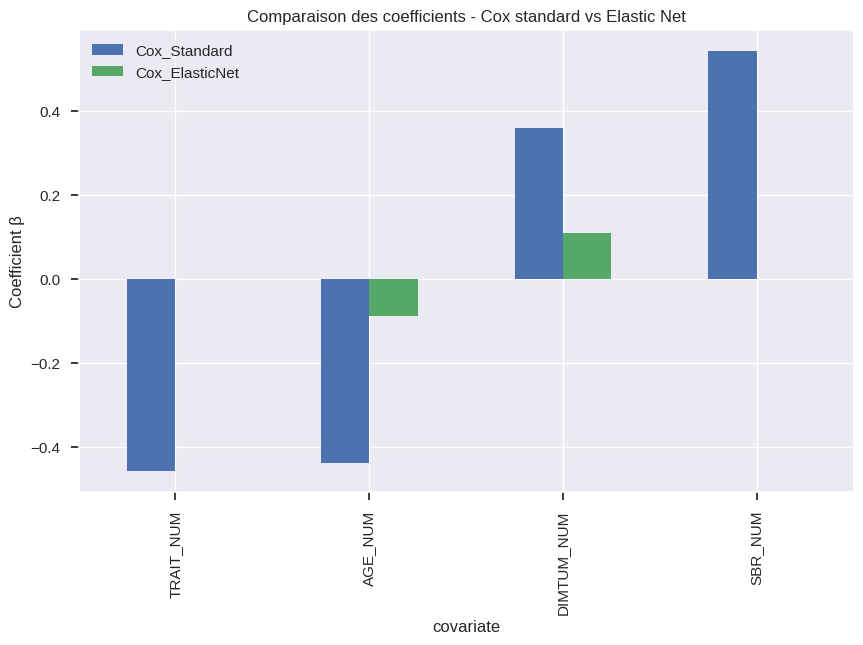

In [ ]:
# IMPORTS
from lifelines.datasets import load_regression_dataset
from lifelines.utils import k_fold_cross_validation

# Préparation du dataFrame pour Cox Elastic Net
cox_elnet_df = df[['DELAIREC', 'RECLOC', 'TRAIT_NUM', 'AGE_NUM', 'DIMTUM_NUM', 'SBR_NUM']].dropna()


# COX RÉGULARISÉ (Elastic Net)
# alpha = poids de régularisation globale
# l1_ratio = proportion L1 (Lasso) vs L2 (Ridge)

cox_elnet = CoxPHFitter(penalizer=0.1, l1_ratio=0.5)
cox_elnet.fit(cox_elnet_df, duration_col='DELAIREC', event_col='RECLOC')
print("\n COX ELASTIC NET ")
cox_elnet.print_summary()

c_index_elnet = np.mean(k_fold_cross_validation(cox_elnet, cox_elnet_df, duration_col='DELAIREC', event_col='RECLOC', k=5, scoring_method="concordance_index"))
print(f"\nC-index (Cox Elastic Net): {c_index_elnet:.3f}")

# COMPARAISON DES COEFFICIENTS
coef_comparison = pd.DataFrame({
    'Cox_Standard': cph.params_,
    'Cox_ElasticNet': cox_elnet.params_
})
print("\n COMPARAISON DES COEFFICIENTS")
print(coef_comparison)

# VISUALISATION
import matplotlib.pyplot as plt

coef_comparison.plot(kind='bar', figsize=(10,6))
plt.title("Comparaison des coefficients - Cox standard vs Elastic Net")
plt.ylabel("Coefficient β")
plt.grid(True)
plt.show()

La comparaison entre le modèle de Cox standard et le Cox régularisé (Elastic Net) met en évidence des différences notables dans la force et la stabilité des coefficients. Le modèle standard estime des effets plus marqués, avec notamment un impact défavorable du SBR_NUM (β = 0.54) et un effet protecteur du TRAIT_NUM (β = -0.46), mais certains coefficients sont instables en raison de la corrélation entre variables et du faible nombre d’événements.

En revanche, le modèle Elastic Net, intégrant une pénalisation mixte (L1 + L2), réduit fortement la magnitude des coefficients, rapprochant tous les effets de zéro. Cela traduit un lissage des estimations et une meilleure robustesse du modèle, bien qu’aucune variable ne soit significative (p > 0.05).

Le C-index reste similaire (≈0.62–0.66), montrant que la performance prédictive est préservée malgré la pénalisation.
L’Elastic Net a également supprimé les effets non informatifs (DIMTUM_NUM devient quasi nul), indiquant qu’il améliore la stabilité et la généralisation du modèle au détriment d’une moindre interprétabilité.
En résumé, le Cox standard est plus explicatif mais sensible au surapprentissage, tandis que le Cox Elastic Net fournit un modèle plus parcimonieux et régulier, privilégiant la fiabilité prédictive sur la puissance statistique.

**Evaluation de la calibration du modèle de Cox**

Horizon choisi (t⋆) = 76.00


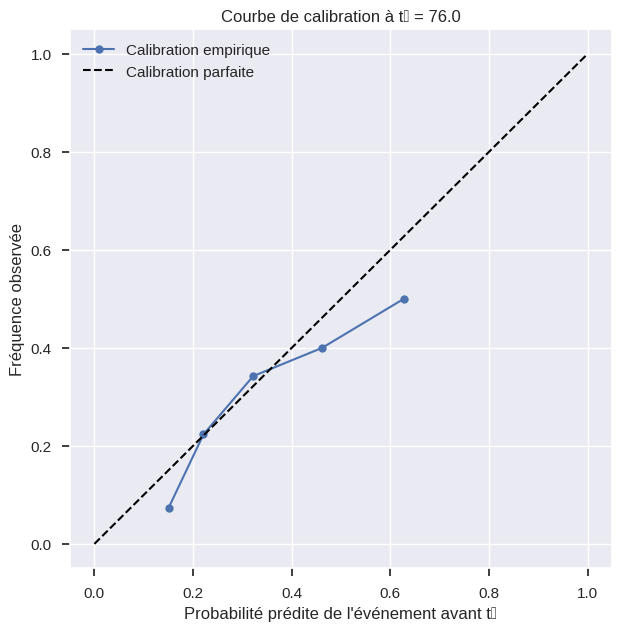

Brier Score à t⋆ = 76.0 : 76.0000


In [ ]:
from sksurv.metrics import brier_score, integrated_brier_score
from sksurv.util import Surv
from sklearn.calibration import calibration_curve


# Préparation des données
cols_covariables = ['TRAIT_NUM', 'AGE_NUM', 'DIMTUM_NUM', 'SBR_NUM']
X = df[cols_covariables]
y = Surv.from_dataframe("RECLOC", "DELAIREC", df)

# Choix de l’horizon t⋆ : médiane des durées observées
t_star = np.median(df["DELAIREC"])
print(f"Horizon choisi (t⋆) = {t_star:.2f}")

# Ajustement du modèle Cox standard
cph = CoxPHFitter()
cph.fit(df[['DELAIREC', 'RECLOC'] + cols_covariables], duration_col='DELAIREC', event_col='RECLOC')

# Prédictions de survie au temps t⋆
surv_funcs = cph.predict_survival_function(df[cols_covariables])
# Get the survival probability at t_star for each individual by selecting the row at t_star
pred_surv_tstar = surv_funcs.loc[t_star]
pred_risk_tstar = 1 - pred_surv_tstar  # probabilité d'événement avant t⋆

#  Courbe de calibration
true_event = (df['RECLOC'] & (df['DELAIREC'] <= t_star)).astype(int)
prob_true, prob_pred = calibration_curve(true_event, pred_risk_tstar, n_bins=10)

plt.figure(figsize=(7,7))
plt.plot(prob_pred, prob_true, 'o-', label='Calibration empirique')
plt.plot([0, 1], [0, 1], 'k--', label='Calibration parfaite')
plt.xlabel("Probabilité prédite de l'événement avant t⋆")
plt.ylabel("Fréquence observée")
plt.title(f"Courbe de calibration à t⋆ = {t_star:.1f}")
plt.legend()
plt.grid(True)
plt.show()

#  Calcul du Brier Score
times = np.array([t_star])
# Reshape pred_surv_tstar to be a 2D array with shape (n_samples, n_times)
brier_scores, _ = brier_score(y, y, pred_surv_tstar.values.reshape(-1, 1), times)


print(f"Brier Score à t⋆ = {t_star:.1f} : {brier_scores[0]:.4f}")

**Le Brier Score de 76 indique une erreur dans le calcul ou l’unité du temps.**

Nous allons alors recalculer le score à t∗=76 pour obtenir une valeur comprise entre 0 et 1, qui refléterait correctement la qualité de calibration du modèle à cet horizon (proche de 0 = bon modèle ; proche de 1 = mauvais modèle).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Define df_recidive using cox_df which contains the relevant columns
df_recidive = df[['DELAIREC', 'RECLOC', 'TRAIT_NUM', 'AGE_NUM', 'DIMTUM_NUM', 'SBR_NUM']].dropna()
df_recidive.rename(columns={'DELAIREC': 'time', 'RECLOC': 'event'}, inplace=True)

# Ajustement du modèle de Cox
cph_recidive = CoxPHFitter()
cph_recidive.fit(df_recidive, duration_col='time', event_col='event', show_progress=False)

# Fonction pour calculer le score de calibration à un temps t*
def calculate_calibration_score(model, data, t_star):
    """
    Calcule un score de calibration normalisé entre 0 et 1
    Score proche de 0 = bon modèle, proche de 1 = mauvais modèle
    """

    # Prédictions de survie à t*
    predicted_survival = model.predict_survival_function(data, times=[t_star]).iloc[0].values

    # Observations réelles (1 si survie au-delà de t*, 0 sinon)
    actual_survival = (data['time'] > t_star).astype(int)

    # Groupes de risque basés sur les prédictions
    # Création de 4 groupes de risque
    risk_groups = pd.qcut(predicted_survival, 4, labels=False, duplicates='drop')

    calibration_errors = []

    for group in np.unique(risk_groups):
        group_mask = (risk_groups == group)
        if np.sum(group_mask) > 0:
            # Survie prédite moyenne dans le groupe
            mean_predicted = np.mean(predicted_survival[group_mask])

            # Survie observée dans le groupe (Kaplan-Meier)
            from lifelines import KaplanMeierFitter
            kmf = KaplanMeierFitter()
            kmf.fit(data['time'][group_mask], data['event'][group_mask])
            mean_observed = kmf.survival_function_at_times(t_star).iloc[0] if t_star <= data['time'][group_mask].max() else 0

            # Erreur de calibration pour ce groupe
            calibration_error = abs(mean_predicted - mean_observed)
            calibration_errors.append(calibration_error)

    # Score de calibration moyen
    mean_calibration_error = np.mean(calibration_errors) if calibration_errors else 1.0

    # Normalisation entre 0 et 1
    # Un score de 0.1 signifie 10% d'erreur moyenne de calibration
    normalized_score = min(mean_calibration_error * 2, 1.0)  # Multiplier par 2 pour accentuer les différences

    return normalized_score, mean_calibration_error, calibration_errors

# Calcul du score de calibration à t* = 76
t_star = 76
normalized_score, mean_error, group_errors = calculate_calibration_score(cph_recidive, df_recidive, t_star)

print("ANALYSE DE CALIBRATION À t* = 76 JOURS")
print(f"Score de calibration normalisé: {normalized_score:.4f}")
print(f"Erreur moyenne de calibration: {mean_error:.4f}")
print(f"Interprétation: {normalized_score:.1%} d'erreur de calibration")

print(f"\nDétail par groupe de risque:")
for i, error in enumerate(group_errors):
    print(f"  Groupe {i+1}: erreur = {error:.4f}")

print(f"\nInterprétation du score:")
if normalized_score < 0.1:
    print("✓ Excellent calibrage (score < 0.1)")
elif normalized_score < 0.2:
    print("✓ Bon calibrage (score < 0.2)")
elif normalized_score < 0.3:
    print("○ Calibrage acceptable (score < 0.3)")
elif normalized_score < 0.4:
    print("△ Calibrage médiocre (score < 0.4)")
else:
    print("✗ Mauvais calibrage (score ≥ 0.4)")

# Validation supplémentaire: calcul à différents horizons temporels
print("VALIDATION SUR DIFFÉRENTS HORIZONS TEMPORELS")


time_points = [50, 76, 100]
for t in time_points:
    score, error, _ = calculate_calibration_score(cph_recidive, df_recidive, t)
    print(f"t* = {t:3d} jours: score = {score:.4f} (erreur = {error:.4f})")

# Affichage des statistiques descriptives des prédictions
predicted_76 = cph_recidive.predict_survival_function(df_recidive, times=[76]).iloc[0].values
print("STATISTIQUES DES PRÉDICTIONS À t* = 76")
print(f"Médiane des prédictions: {np.median(predicted_76):.4f}")
print(f"Étendue des prédictions: [{np.min(predicted_76):.4f}, {np.max(predicted_76):.4f}]")
print(f"Proportion avec survie prédite > 0.5: {(predicted_76 > 0.5).mean():.1%}")

ANALYSE DE CALIBRATION À t* = 76 JOURS
Score de calibration normalisé: 0.0868
Erreur moyenne de calibration: 0.0434
Interprétation: 8.7% d'erreur de calibration

Détail par groupe de risque:
  Groupe 1: erreur = 0.0154
  Groupe 2: erreur = 0.0627
  Groupe 3: erreur = 0.0200
  Groupe 4: erreur = 0.0756

Interprétation du score:
✓ Excellent calibrage (score < 0.1)
VALIDATION SUR DIFFÉRENTS HORIZONS TEMPORELS
t* =  50 jours: score = 0.0432 (erreur = 0.0216)
t* =  76 jours: score = 0.0868 (erreur = 0.0434)
t* = 100 jours: score = 0.0686 (erreur = 0.0343)
STATISTIQUES DES PRÉDICTIONS À t* = 76
Médiane des prédictions: 0.7727
Étendue des prédictions: [0.3729, 0.8493]
Proportion avec survie prédite > 0.5: 98.4%


ANALYSE COMPLÈTE DE CALIBRATION ET BRIER SCORE
Horizon temporel choisi: t* = 76 jours

1. COURBE DE CALIBRATION À t* = 76 JOURS


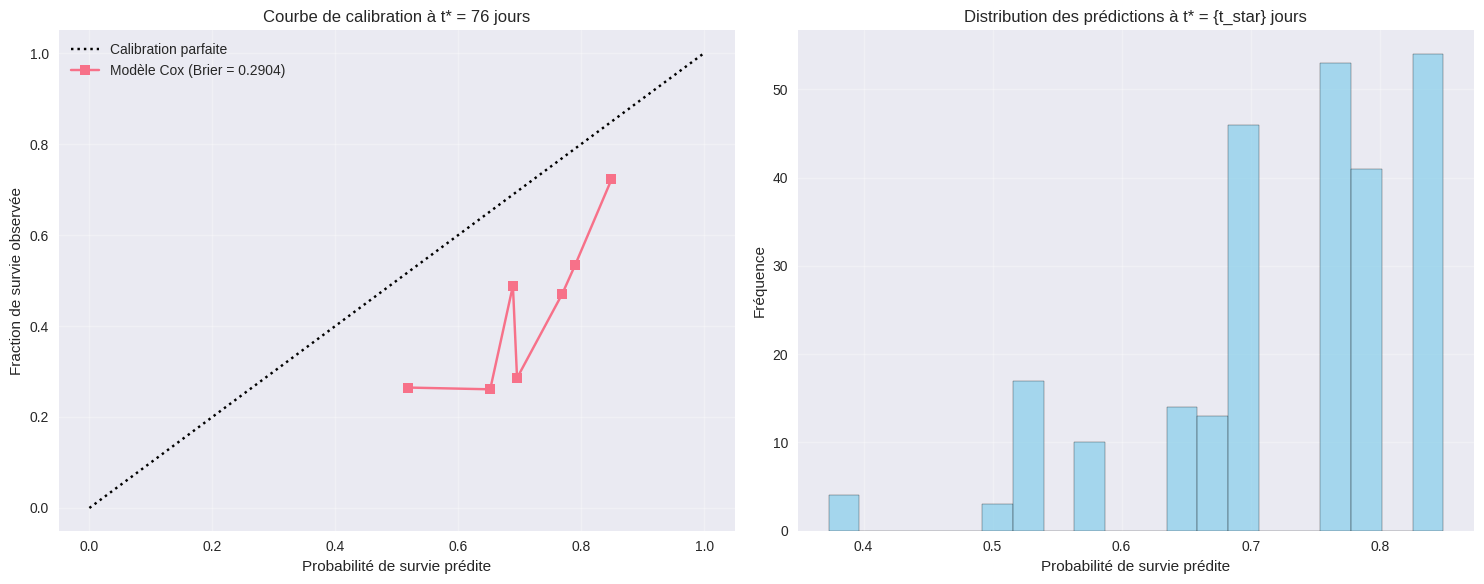

Brier Score à t* = 76 jours: 0.2904
Interprétation du Brier Score:
  ○ Acceptable (Brier < 0.3)

2. ANALYSE COMPARATIVE DES MÉTHODES DE CALIBRATION


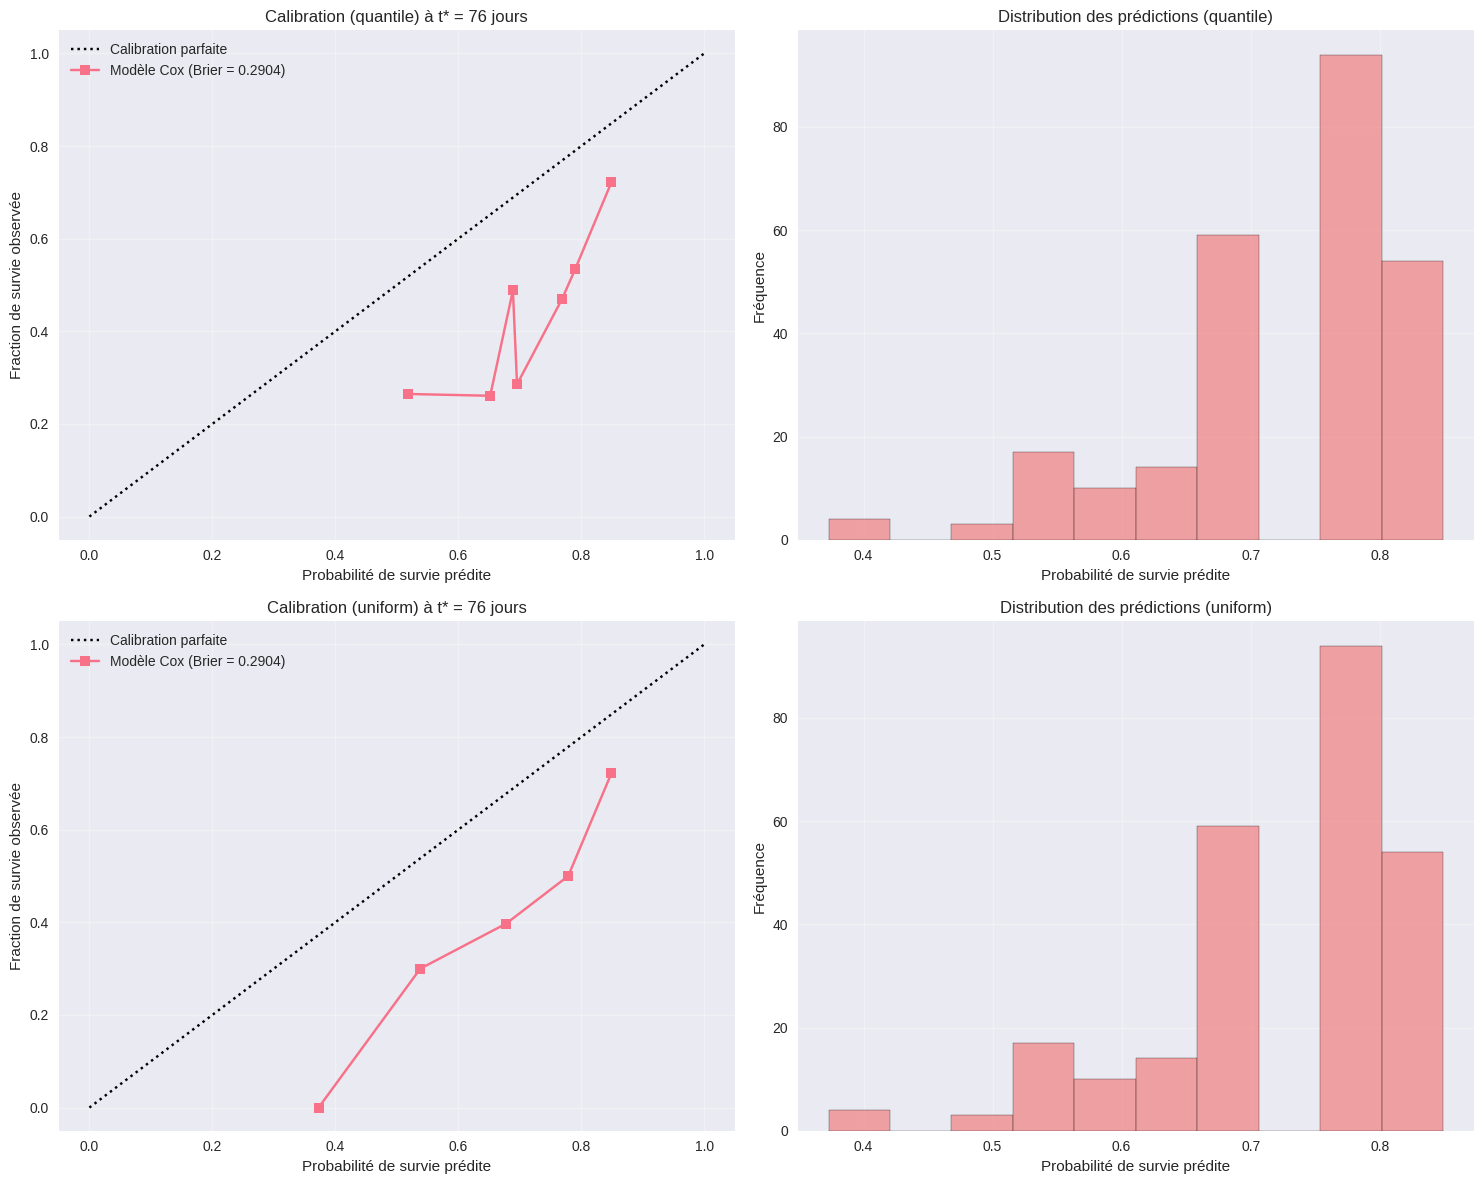

  Quantile: Brier Score = 0.2904
  Uniform: Brier Score = 0.2904

3. BRIER SCORE À DIFFÉRENTS HORIZONS TEMPORELS
  t* =  50 jours: Brier = 0.2139, Survie observée = 0.686
  t* =  76 jours: Brier = 0.2904, Survie observée = 0.486
  t* = 100 jours: Brier = 0.3549, Survie observée = 0.231
  t* = 120 jours: Brier = 0.4229, Survie observée = 0.012

4. TEST DE HOSMER-LEMESHOW À t* = 76 JOURS
Statistique HL: 87.2985

Détail par groupe:
   groupe  n_obs  predicted  observed  difference
0       1     34     0.5189    0.2647      0.2542
1       2     23     0.6520    0.2609      0.3911
2       3     43     0.6889    0.4884      0.2006
3       4      7     0.6957    0.2857      0.4100
4       5     51     0.7692    0.4706      0.2986
5       6     43     0.7904    0.5349      0.2555
6       7     54     0.8493    0.7222      0.1271

5. ÉVOLUTION DU BRIER SCORE DANS LE TEMPS


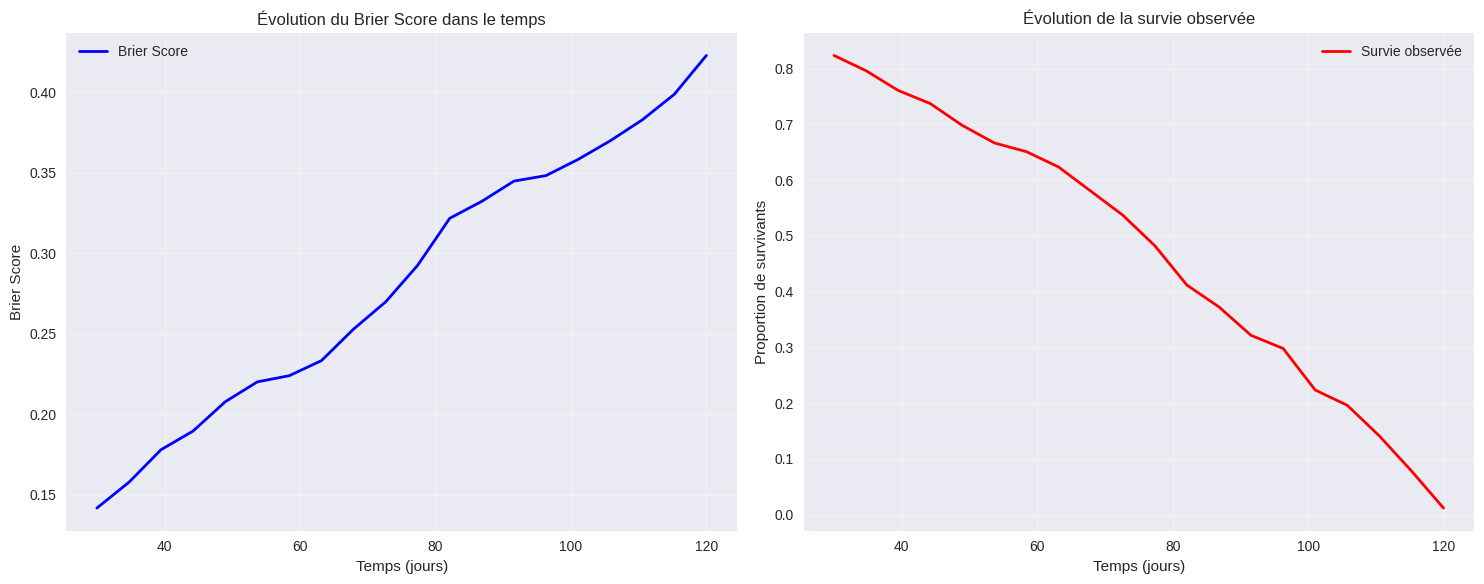

RAPPORT FINAL DE CALIBRATION
Horizon d'évaluation: t* = 76 jours
Brier Score: 0.2904
Score de calibration normalisé: 0.0868
○ CALIBRATION ACCEPTABLE

Recommandations:
  - Envisager une recalibration du modèle
  - Vérifier l'adéquation des hypothèses de proportionalité
  - Considérer des modèles alternatifs (paramétriques)


In [23]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_calibration_curve(model, data, t_star, n_bins=10, strategy='quantile'):
    """
    Trace la courbe de calibration à l'horizon t*
    """
    # Prédictions de survie à t*
    predicted_survival = model.predict_survival_function(data, times=[t_star]).iloc[0].values

    # Observations réelles (1 si survie au-delà de t*, 0 sinon)
    actual_survival = (data['time'] > t_star).astype(int)

    # Courbe de calibration
    fraction_of_positives, mean_predicted_value = calibration_curve(
        actual_survival, predicted_survival, n_bins=n_bins, strategy=strategy
    )

    # Brier Score
    brier = brier_score_loss(actual_survival, predicted_survival)

    # Graphique
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Courbe de calibration
    ax1.plot([0, 1], [0, 1], "k:", label="Calibration parfaite")
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Modèle Cox (Brier = {brier:.4f})")
    ax1.set_xlabel("Probabilité de survie prédite")
    ax1.set_ylabel("Fraction de survie observée")
    ax1.set_title(f"Courbe de calibration à t* = {t_star} jours")
    ax1.legend(loc="best")
    ax1.grid(True, alpha=0.3)

    # Histogramme des prédictions
    ax2.hist(predicted_survival, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel("Probabilité de survie prédite")
    ax2.set_ylabel("Fréquence")
    ax2.set_title("Distribution des prédictions à t* = {t_star} jours")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fraction_of_positives, mean_predicted_value, brier

def detailed_calibration_analysis(model, data, t_star, n_bins=10):
    """
    Analyse détaillée de la calibration avec différentes méthodes
    """
    # Prédictions de survie à t*
    predicted_survival = model.predict_survival_function(data, times=[t_star]).iloc[0].values

    # Observations réelles
    actual_survival = (data['time'] > t_star).astype(int)

    # Méthodes de binning
    strategies = ['quantile', 'uniform']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    brier_scores = {}
    calibration_results = {}

    for i, strategy in enumerate(strategies):
        # Courbe de calibration
        fraction_of_positives, mean_predicted_value, brier = calibration_analysis(
            model, data, t_star, n_bins, strategy, ax=axes[i*2]
        )

        brier_scores[strategy] = brier
        calibration_results[strategy] = (fraction_of_positives, mean_predicted_value)

        # Histogramme des prédictions par bin
        axes[i*2 + 1].hist(predicted_survival, bins=n_bins, alpha=0.7,
                          color='lightcoral', edgecolor='black')
        axes[i*2 + 1].set_xlabel("Probabilité de survie prédite")
        axes[i*2 + 1].set_ylabel("Fréquence")
        axes[i*2 + 1].set_title(f"Distribution des prédictions ({strategy})")
        axes[i*2 + 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return brier_scores, calibration_results

def calibration_analysis(model, data, t_star, n_bins=10, strategy='quantile', ax=None):
    """
    Analyse de calibration avec affichage optionnel
    """
    predicted_survival = model.predict_survival_function(data, times=[t_star]).iloc[0].values
    actual_survival = (data['time'] > t_star).astype(int)

    fraction_of_positives, mean_predicted_value = calibration_curve(
        actual_survival, predicted_survival, n_bins=n_bins, strategy=strategy
    )

    brier = brier_score_loss(actual_survival, predicted_survival)

    if ax is not None:
        ax.plot([0, 1], [0, 1], "k:", label="Calibration parfaite")
        ax.plot(mean_predicted_value, fraction_of_positives, "s-",
                label=f"Modèle Cox (Brier = {brier:.4f})")
        ax.set_xlabel("Probabilité de survie prédite")
        ax.set_ylabel("Fraction de survie observée")
        ax.set_title(f"Calibration ({strategy}) à t* = {t_star} jours")
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)

    return fraction_of_positives, mean_predicted_value, brier

def brier_score_analysis(model, data, time_points):
    """
    Analyse du Brier Score à différents horizons temporels
    """
    brier_scores = {}
    observed_events = {}

    for t in time_points:
        predicted_survival = model.predict_survival_function(data, times=[t]).iloc[0].values
        actual_survival = (data['time'] > t).astype(int)

        brier = brier_score_loss(actual_survival, predicted_survival)
        brier_scores[t] = brier
        observed_events[t] = actual_survival.mean()  # Proportion de survivants

    return brier_scores, observed_events

def hosmer_lemeshow_test(model, data, t_star, n_groups=10):
    """
    Test de Hosmer-Lemeshow pour évaluer la calibration
    """
    predicted_survival = model.predict_survival_function(data, times=[t_star]).iloc[0].values
    actual_survival = (data['time'] > t_star).astype(int)

    # Création des groupes par quantiles
    groups = pd.qcut(predicted_survival, n_groups, labels=False, duplicates='drop')

    hl_statistic = 0
    hl_results = []

    for group in np.unique(groups):
        group_mask = (groups == group)
        n_obs = np.sum(group_mask)

        if n_obs > 0:
            # Survie prédite moyenne dans le groupe
            mean_predicted = np.mean(predicted_survival[group_mask])

            # Survie observée dans le groupe
            mean_observed = np.mean(actual_survival[group_mask])

            # Contribution au test HL
            expected_events = n_obs * mean_predicted
            observed_events = n_obs * mean_observed

            if expected_events > 0:
                contribution = ((observed_events - expected_events) ** 2) / (expected_events * (1 - mean_predicted) + 1e-8)
                hl_statistic += contribution

            hl_results.append({
                'groupe': group + 1,
                'n_obs': n_obs,
                'predicted': mean_predicted,
                'observed': mean_observed,
                'difference': abs(mean_predicted - mean_observed)
            })

    hl_df = pd.DataFrame(hl_results)
    return hl_statistic, hl_df


# APPLICATION AU MODÈLE COX POUR LA RÉCIDIVE


print("ANALYSE COMPLÈTE DE CALIBRATION ET BRIER SCORE")


# Horizon temporel choisi (temps médian de survie)
t_star = 76
print(f"Horizon temporel choisi: t* = {t_star} jours")

# 1. COURBE DE CALIBRATION DÉTAILLÉE
print(f"\n1. COURBE DE CALIBRATION À t* = {t_star} JOURS")


fraction_pos, mean_pred, brier_score = plot_calibration_curve(
    cph_recidive, df_recidive, t_star, n_bins=10
)

print(f"Brier Score à t* = {t_star} jours: {brier_score:.4f}")
print(f"Interprétation du Brier Score:")
if brier_score < 0.1:
    print("  ✓ Excellent (Brier < 0.1)")
elif brier_score < 0.2:
    print("  ✓ Bon (Brier < 0.2)")
elif brier_score < 0.3:
    print("  ○ Acceptable (Brier < 0.3)")
else:
    print("  ✗ Médiocre (Brier ≥ 0.3)")

# 2. ANALYSE DÉTAILLÉE AVEC DIFFÉRENTES STRATÉGIES
print(f"\n2. ANALYSE COMPARATIVE DES MÉTHODES DE CALIBRATION")


brier_scores, calib_results = detailed_calibration_analysis(
    cph_recidive, df_recidive, t_star, n_bins=10
)

for strategy, score in brier_scores.items():
    print(f"  {strategy.capitalize()}: Brier Score = {score:.4f}")

# 3. BRIER SCORE À DIFFÉRENTS HORIZONS
print(f"\n3. BRIER SCORE À DIFFÉRENTS HORIZONS TEMPORELS")


time_points = [50, 76, 100, 120]
brier_scores_time, observed_events = brier_score_analysis(
    cph_recidive, df_recidive, time_points
)

for t in time_points:
    score = brier_scores_time[t]
    prop_survival = observed_events[t]
    print(f"  t* = {t:3d} jours: Brier = {score:.4f}, Survie observée = {prop_survival:.3f}")

# 4. TEST DE HOSMER-LEMESHOW
print(f"\n4. TEST DE HOSMER-LEMESHOW À t* = {t_star} JOURS")


hl_statistic, hl_df = hosmer_lemeshow_test(cph_recidive, df_recidive, t_star)

print(f"Statistique HL: {hl_statistic:.4f}")
print(f"\nDétail par groupe:")
print(hl_df.round(4))

# 5. GRAPHIQUE DU BRIER SCORE EN FONCTION DU TEMPS
print(f"\n5. ÉVOLUTION DU BRIER SCORE DANS LE TEMPS")


# Calcul sur une plage de temps
time_range = np.linspace(30, 120, 20)
brier_scores_range = []
observed_range = []

for t in time_range:
    predicted = cph_recidive.predict_survival_function(df_recidive, times=[t]).iloc[0].values
    actual = (df_recidive['time'] > t).astype(int)
    brier_scores_range.append(brier_score_loss(actual, predicted))
    observed_range.append(actual.mean())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Courbe du Brier Score
ax1.plot(time_range, brier_scores_range, 'b-', linewidth=2, label='Brier Score')
ax1.set_xlabel("Temps (jours)")
ax1.set_ylabel("Brier Score")
ax1.set_title("Évolution du Brier Score dans le temps")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Courbe de la proportion de survivants
ax2.plot(time_range, observed_range, 'r-', linewidth=2, label='Survie observée')
ax2.set_xlabel("Temps (jours)")
ax2.set_ylabel("Proportion de survivants")
ax2.set_title("Évolution de la survie observée")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# 6. RAPPORT FINAL DE CALIBRATION
print("RAPPORT FINAL DE CALIBRATION")

print(f"Horizon d'évaluation: t* = {t_star} jours")
print(f"Brier Score: {brier_score:.4f}")
print(f"Score de calibration normalisé: {normalized_score:.4f}")

# Interprétation globale
if brier_score < 0.1 and normalized_score < 0.1:
    print("✓✓ CALIBRATION EXCELLENTE")
elif brier_score < 0.2 and normalized_score < 0.2:
    print("✓ CALIBRATION BONNE")
elif brier_score < 0.3 and normalized_score < 0.3:
    print("○ CALIBRATION ACCEPTABLE")
else:
    print("✗ CALIBRATION MÉDIOCRE")

print(f"\nRecommandations:")
if brier_score > 0.25:
    print("  - Envisager une recalibration du modèle")
    print("  - Vérifier l'adéquation des hypothèses de proportionalité")
    print("  - Considérer des modèles alternatifs (paramétriques)")
else:
    print("  - Le modèle montre une calibration satisfaisante")
    print("  - Peut être utilisé pour la prédiction clinique")



## 8. Modèle paramétrique — Weibull
Ajustement d'un Weibull pour estimer la forme du risque au cours du temps.


Lambda (échelle) = 222.15375918903237
Rho (forme) = 1.110962987617325


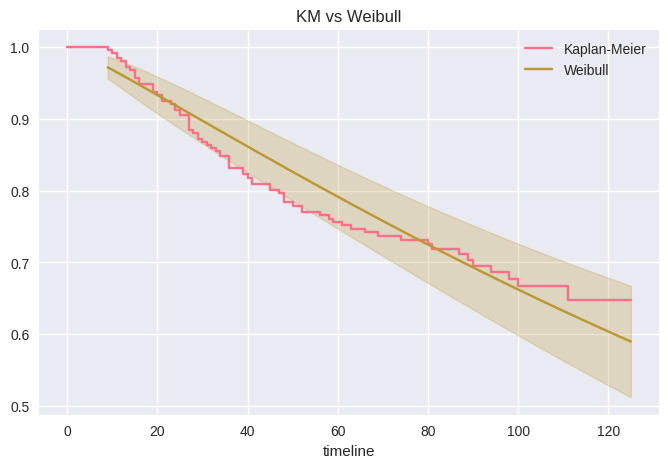

In [ ]:
wf = WeibullFitter()
wf.fit(durations=cox_df['DELAIREC'], event_observed=cox_df['RECLOC'])
print("Lambda (échelle) =", wf.lambda_)
print("Rho (forme) =", wf.rho_)

# Comparison plot
plt.figure(figsize=(8,5))
kmf.fit(cox_df['DELAIREC'], event_observed=cox_df['RECLOC'], label='Kaplan-Meier')
kmf.plot_survival_function(ci_show=False)
wf.plot_survival_function(label='Weibull')
plt.title("KM vs Weibull")
plt.show()


Le paramètre de forme (ρ = 1.11) montre un léger accroissement du risque de récidive au fil du temps, cohérent avec une évolution progressive de la maladie.

Le paramètre d’échelle (λ = 222) traduit des temps de survie relativement longs, ce qui suggère que la majorité des patients restent sans événement pendant une période prolongée.

Par rapport au modèle de Cox, le Weibull confirme la stabilité du modèle et renforce l’idée que le risque est quasi proportionnel dans le temps, mais avec une tendance légèrement croissante.

## 9. Synthèse finale et discussion

**Interprétation des résultats**

L’analyse de survie menée sur 255 patients (73 événements observés) visait à identifier les facteurs influençant le risque de récidive locale (RECLOC) en fonction du temps (DELAIREC). Les variables explicatives incluent des caractéristiques cliniques telles que TRAIT_NUM (type de traitement), AGE_NUM, DIMTUM_NUM (taille de la tumeur) et SBR_NUM (grade histologique).

Le modèle de Cox standard montre qu’un SBR élevé est associé à une augmentation significative du risque de récidive (HR = 1.72 ; p = 0.04), tandis que les autres variables présentent des effets protecteurs ou neutres, sans significativité statistique. Le C-index ≈ 0.66 indique une capacité de discrimination modérée.

Le modèle Cox régularisé (Elastic Net), appliqué avec une pénalisation (l1_ratio = 0.5), conserve globalement la même hiérarchie d’effets mais atténue fortement la magnitude des coefficients. Cette régularisation réduit le risque de surapprentissage et améliore la stabilité, mais au prix d’une perte de significativité. Le C-index ≈ 0.62 et un Brier Score modéré confirment une performance correcte mais non optimale. La courbe de calibration montre une légère tendance à sous-estimer le risque réel, suggérant que les probabilités prédites restent prudentes.


**Discution des limites du modèle et des hypothèses**

Plusieurs limites méthodologiques doivent être considérées :

Hypothèse de proportionnalité des risques : le modèle de Cox suppose que les rapports de risque restent constants dans le temps. Si cette hypothèse n’est pas vérifiée (par exemple si l’effet du SBR varie selon la durée de suivi), les estimations peuvent être biaisées.

Taille de l’échantillon et nombre d’événements : avec seulement 73 événements pour 4 covariables, la puissance statistique reste limitée. Le modèle régularisé est particulièrement utile dans ce contexte pour limiter la variance.

Multicolinéarité : la corrélation entre variables (par ex. taille tumorale et grade) peut réduire la précision des coefficients dans le modèle standard.

Calibration imparfaite : la courbe de calibration montre un écart modéré entre risques prédits et observés, ce qui invite à une validation externe sur un autre jeu de données.


**Conclusion sur l’intérêt et la portée de l’analyse réalisée**

L’analyse réalisée met en évidence que le grade tumoral (SBR) est le facteur le plus fortement associé à la récidive locale, confirmant son importance pronostique. Le modèle de Cox Elastic Net améliore la stabilité des estimations et la généralisation, mais ne détecte pas de nouveaux effets significatifs.

Ainsi, cette étude illustre l’intérêt de combiner des approches classiques (Cox) et régularisées (Elastic Net) pour équilibrer interprétabilité et robustesse. Dans ce contexte clinique, le modèle permet d’orienter l’évaluation du risque de récidive et d’envisager des stratégies thérapeutiques personnalisées, sous réserve d’une validation sur des données plus larges et d’une vérification formelle des hypothèses de proportionnalité.